In [1]:
import matplotlib.pyplot as plt

from dataset import Dataset, ActivityType, SAMPLE_RATE, Sensor
import numpy as np
from scipy.fftpack import fft, fftfreq, ifft
from scipy.signal import stft
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

# Prepare dataset directory

Dataset is from `PhysioNet` can be retrived from this URL:

https://physionet.org/content/accelerometry-walk-climb-drive/1.0.0/

You can download and extract it under `dataset` directory or alternatively run the following cell:

In [10]:
!wget -c --timeout 10 https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip -O dataset.zip
!unzip -d dataset -q dataset.zip
!echo "Done!"

--2023-02-19 15:23:33--  https://physionet.org/static/published-projects/accelerometry-walk-climb-drive/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Done!


In [91]:
!ls dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data/

id00b70b13.csv	id3e3e50c7.csv	id82b9735c.csv	idb221f542.csv	idf540d82b.csv
id079c763c.csv	id4ea159a8.csv	id86237981.csv	idbae5a811.csv	idf5e3678b.csv
id1165e00c.csv	id5308a7d6.csv	id8af5374b.csv	idc735fc09.csv	idfc5f05e4.csv
id1c7e64ad.csv	id5993bf4a.csv	id8e66893c.csv	idc91a49d0.csv	idff99de96.csv
id1f372081.csv	id650857ca.csv	id9603e9c3.csv	idd80ac2b4.csv
id34e056c8.csv	id687ab496.csv	ida61e8ddf.csv	idecc9265e.csv
id37a54bbf.csv	id7c20ee7a.csv	idabd0c53c.csv	idf1ce9a0f.csv


# Read dataset

Using `Dataset` class from `dataset.py` module, we can easily interact with accelerometer data.
It reads all individual CSV files from different subjects and gives a nice API to query data.

First, we need to create an object from `Dataset` class:

In [92]:
dset = Dataset("./dataset/labeled-raw-accelerometry-data-captured-during-walking-stair-climbing-and-driving-1.0.0/raw_accelerometry_data")
dset._df

,activity,time_s,lw_x,lw_y,lw_z,lh_x,lh_y,lh_z,la_x,la_y,la_z,ra_x,ra_y,ra_z,timestamp
0,99,0.01,0.039,1.020,-0.020,-0.180,1.234,0.023,0.156,0.855,-0.582,0.887,0.449,0.074,0
1,99,0.02,-0.629,-0.461,0.973,-0.246,0.137,0.969,-0.707,0.559,0.449,-0.027,0.141,0.934,1
2,99,0.03,-0.926,-1.262,0.691,0.238,-0.328,1.219,-1.445,1.367,0.367,-0.164,0.660,1.344,2
3,99,0.04,-0.871,-1.496,-0.246,0.711,-0.484,0.414,-1.660,1.645,-0.543,-0.141,1.027,0.707,3
4,99,0.05,-0.727,-1.621,-0.559,1.031,-0.297,0.145,-1.762,1.676,-0.918,-0.121,1.230,0.438,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325795,99,3257.96,0.000,0.000,0.000,0.820,0.484,-0.324,0.668,0.523,0.480,0.105,-0.988,-0.004,789865
325796,99,3257.97,0.000,0.000,0.000,0.820,0.484,-0.313,0.742,0.473,0.293,0.102,-0.992,-0.008,789866
325797,99,3257.98,0.000,0.000,0.000,0.828,0.484,-0.313,1.555,0.246,0.027,0.105,-0.988,-0.008,789867
325798,99,3257.99,0.000,0.000,0.000,0.832,0.484,-0.305,1.949,0.254,0.246,0.109,-0.988,-0.004,789868


Then using `get` function, different types of data can be read from dataset. For example data related to
Walking activity from left wrist sensor. The function returns numpy array with shape (n x 3) where n is number
of samples drawn from data-set and 3 corresponds to number of axes we have which are X, Y and Z.

Here are three samples:

In [93]:
w = dset.get(ActivityType.WALKING, Sensor.LEFT_WRIST)
d = dset.get(ActivityType.ASCENDING, Sensor.LEFT_WRIST)
a = dset.get(ActivityType.DESCENDING, Sensor.LEFT_WRIST)

print("Walking: ", w.shape)
print("Descending: ", d.shape)
print("Ascending: ", a.shape)

Walking:  (336167, 3)
Descending:  (59253, 3)
Ascending:  (56113, 3)


# Miscellounce functions

In [94]:
def get_magnitude(data, normalize=True):
    """
    Calculate vector magnitude from XYZ axes.
    inputs:
        data: A numpy array with shape (n x 3), n is number of samples and
        there are 3 axes X, Y, Z respectively.
        
        normalize: If true, perform normalization on resulting vector magnitude
        
    output:
        vector magnitude with shape: (n x 1), n is number if samples
    """
    data = np.sum(data ** 2, axis=1)
    if normalize:
        data = (data - data.mean()) / data.std()
    return data


def get_fft(x):
    """
    Compute FFT from input array x
    
    input:
        x: Input array of shape (n x 1)
        
    output:
        A Tuple containing two arrays. First item is frequency and the second item is power
    """
    p = fft(x)
    f = fftfreq(x.shape[0], SAMPLE_RATE)
    p = np.abs(p)

    msk = np.logical_and(f >= 0, f < 20)
    f = f[msk]
    p = p[msk]
     
    return f, p


def low_pass(x, cutoff):
    """
    Pass input signal x through a lowpass filter with a certain cutoff frequency.
    All frequency components higher than cutoff frequency will be damped to zero.
    """
    p = fft(x)
    f = fftfreq(x.shape[0], SAMPLE_RATE)
    p[f >= cutoff] = 0
    p[f < 0] = 0
    y = ifft(p)
    y = np.real(y)
    y = y / y.std()
    return y

def svm_accuracy(clf, X, y):
    correct = 0
    for x, gt in zip(X, y):
        p = clf.predict(x.reshape(1, -1))[0]
        if gt == p:
            correct += 1
    return correct / X.shape[0]

def plot_svm(clf, X, y):
    """
    Given a svm classifier, input data X and its label, it plot data and the lassifier decision boundries
    """
    decision_function = clf.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()

    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )


# Data visualization

## XYZ axes
Now, let's briefly look at the data. Here, three individual axes from a sample walking activity are plotted.

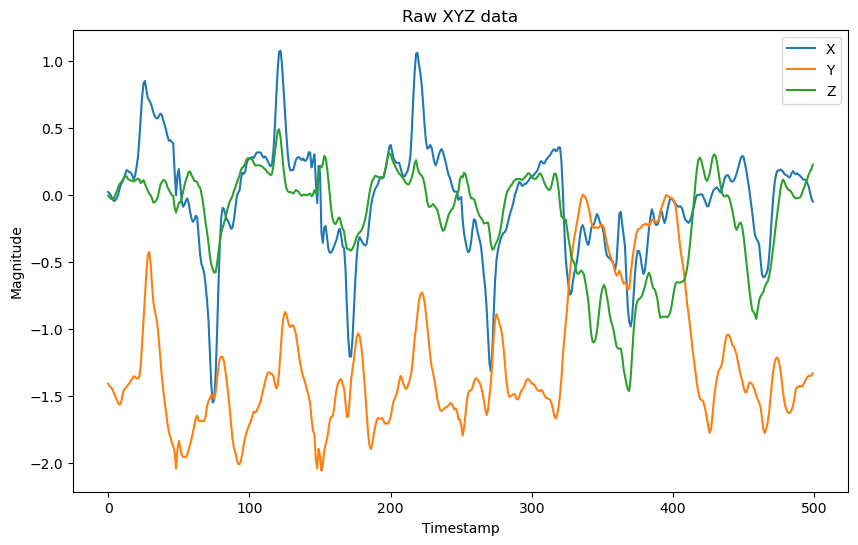

In [95]:
x = dset.get(ActivityType.WALKING, Sensor.LEFT_WRIST, start=1, duration=5)

fig = plt.figure(figsize=(10,6))

plt.plot(x, label=["X", "Y", "Z"])
plt.title("Raw XYZ data")
plt.xlabel("Timestamp")
plt.ylabel("Magnitude")
plt.legend()

## Vector magnitude
To transform three axes to one dimension that represnts original information, vector magnitude
can be computed out of xyz data by this formula:

$vm = \sqrt{x^2 + y^2 + z^2}$

Then, by passing it through a lowpass filter, noise and unwanted
signal can be removed from signal.

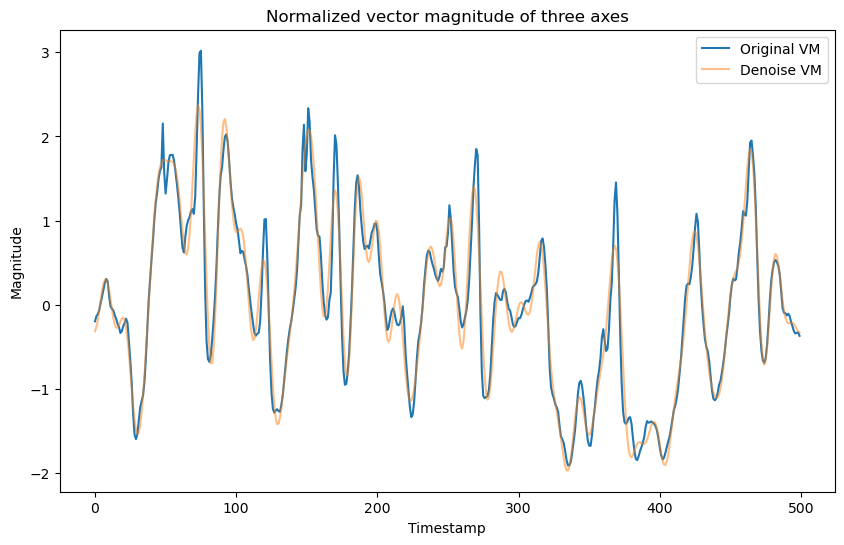

In [96]:
fig = plt.figure(figsize=(10,6))

vm = get_magnitude(x)
vm_denoise = low_pass(vm, 8)

plt.plot(vm, label="Original VM")
plt.plot(vm_denoise, label="Denoise VM", alpha=0.5)
plt.title("Normalized vector magnitude of three axes")
plt.xlabel("Timestamp")
plt.ylabel("Magnitude")
plt.legend()

## Compare VM and FFT of different activities

To have a long shot overview of data, three vector magnitude ofdifferent activities walking, ascending
and descending stairways are plotted side by side.

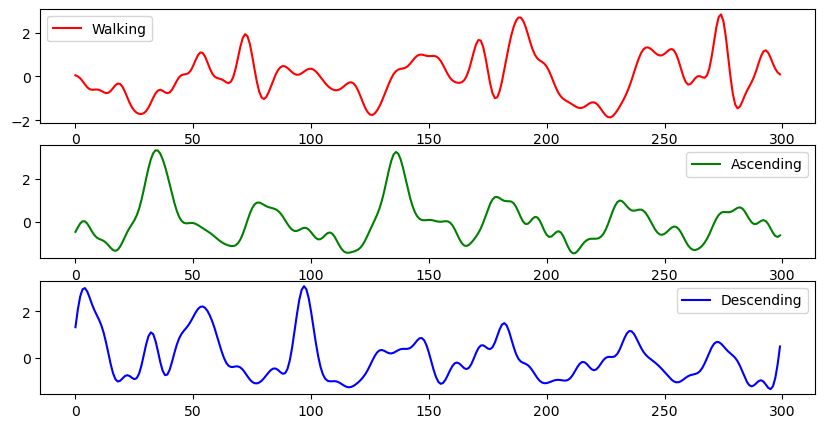

In [97]:
w = dset.get(ActivityType.WALKING, Sensor.LEFT_WRIST, start=20, duration=3)
a = dset.get(ActivityType.ASCENDING, Sensor.LEFT_WRIST, start=20, duration=3)
d = dset.get(ActivityType.DESCENDING, Sensor.LEFT_WRIST, start=20, duration=3)

w = low_pass(get_magnitude(w), 12)
a = low_pass(get_magnitude(a), 12)
d = low_pass(get_magnitude(d), 12)


fig = plt.figure(figsize=(10,5))
fig.tight_layout()

ax = plt.subplot(311)
ax.plot(w, label="Walking", color='red')
ax.legend()

ax = plt.subplot(312)
ax.plot(a, label="Ascending", color='green')
ax.legend()

ax = plt.subplot(313)
ax.plot(d, label="Descending", color='blue')
ax.legend()

plt.legend()

Now, let's take a look at those signals in frequency domain:

Text(0, 0.5, 'Power')

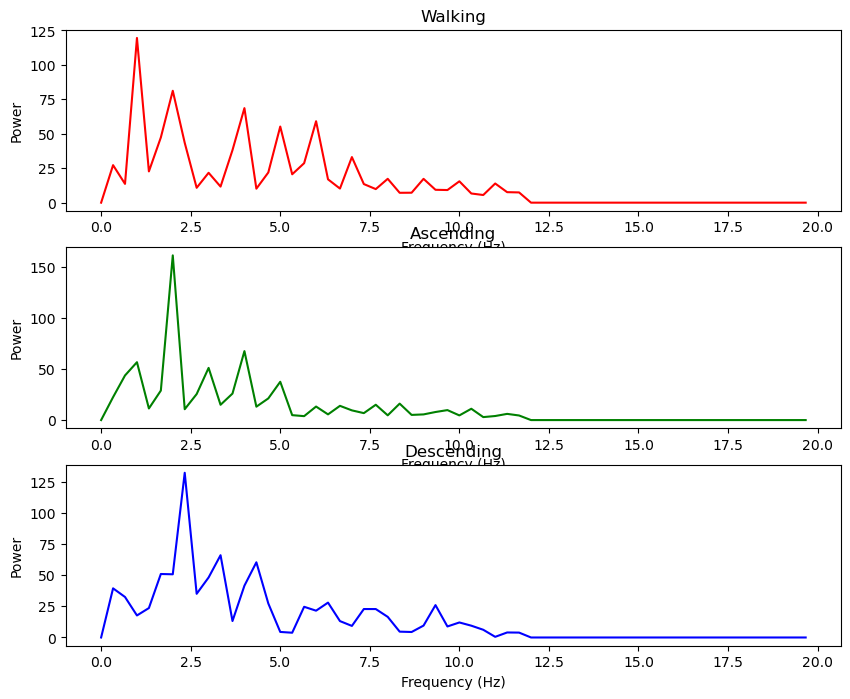

In [98]:
f1, p1 = get_fft(w)
f2, p2 = get_fft(a)
f3, p3 = get_fft(d)

fig = plt.figure(figsize=(10,8))
fig.tight_layout()

ax = plt.subplot(311)
ax.plot(f1, p1, color='red')
ax.set_title("Walking")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")

ax = plt.subplot(312)
ax.plot(f2, p2, color='green')
ax.set_title("Ascending")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")


ax = plt.subplot(313)
ax.plot(f3, p3, color='blue')
ax.set_title("Descending")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")


# Working on raw vector magnitude

The final aim of procrssing this data is to recognize different human activities. To achieve this we performed
different processing methods to see how they can classify different signals. Here, we tried to classify walking
and descending activities.

The first approach we came up with, is to perform PCA directly on vector magnitude.

In [99]:
raw_feats = []
gt = []

for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    raw_feats.append(x)
    gt.append(ActivityType.WALKING.value)
    
    x = dset.get(ActivityType.DESCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    raw_feats.append(x)
    gt.append(ActivityType.DESCENDING.value)

raw_feats = np.array(raw_feats)
gt = np.array(gt)
print(f"Features shape: {raw_feats.shape}")
print(f"Ground truth shape: {gt.shape}")

Features shape: (200, 500)
Ground truth shape: (200,)


## Apply PCA

Percent of dataset explained by PCA: 20.950671849903536 %


Text(0, 0.5, 'PCA Component #2')

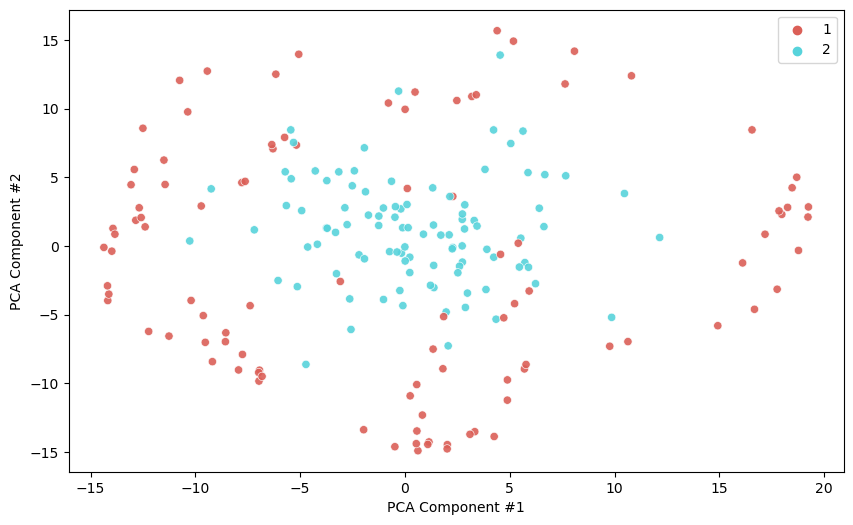

In [100]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(raw_feats)

explain = np.sum(pca.explained_variance_ratio_)
print(f"Percent of dataset explained by PCA: {explain * 100} %")

plt.figure(figsize=(10,6))

x = pca_result[:,0]
y = pca_result[:,1]

sns.scatterplot(
    x=x, y=y,
    hue=gt,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.9,
)
plt.xlabel("PCA Component #1")
plt.ylabel("PCA Component #2")

On the figure above, although two classes are rather nicely seperated, they are not linearly seperable.

## SVM


By utilizing SVM and radial basis function kernel, we can do classify these two activities.
Here you can see decision boundries suggested by SVM visualized by solid line. Also, dashed line
is showing svm margin, means that how much this classifier can tolerant missclassied samples.

Accuracy: 0.905


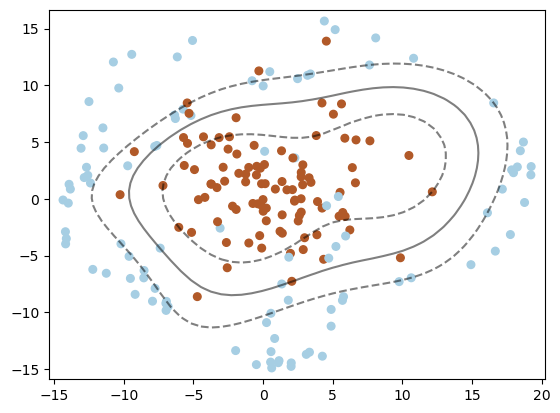

In [101]:
X = pca_result

clf = svm.SVC(kernel='rbf', C=10)
clf.fit(X, gt)

plot_svm(clf, X, gt)

acc = svm_accuracy(clf, X, gt)
print(f"Accuracy: {acc}")

# Extract heuristic features

Now, let's push our idea a bit forward and try to extract some features out of vector magnitude.
Here, we calculated 9 different features, both in frequency and time domain.

Features description:

* `f1`: Dominant frequency providing an estimate of cadence
* `p1`: Partial area under spectrum at `f1`
* `ratio_vm`: Ratio of the partial area under the spectrum related to periodic movement to the complement
* `p1_tp`: Ratio of p1 to the total area under the power spectrum between 0.3-12.5 Hz
* Mean value of power spectrum
* Standard deviation of power spectrum
* Area under spectrum of vector magnitude in time domain
* Summation of positive values of vector magnitude
* Summation of negative values of vector magnitude

In [102]:
def extract_features(x):
    f, p = get_fft(x)
    f1 = f[np.argmax(p)]

    p1 = np.max(p)
    
    ratio_vm = p1 / np.sum(p)
    
    msk = np.logical_and(f > 0.3, f < 12.5)
    p1_tp = p1 / np.sum(p[msk])
    
    return f1, p1, ratio_vm, p1_tp, p.mean(), p.std(), np.sum(x), np.sum(x[x>0]), np.sum(x[x<0])
    
    

# Features and ground truths array
feats = []
gt = []

for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    feats.append(extract_features(x))
    gt.append(ActivityType.WALKING.value)
    
    x = dset.get(ActivityType.DESCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    feats.append(extract_features(x))
    gt.append(ActivityType.DESCENDING.value)


# Convert to numpy array
feats = np.array(feats)
gt = np.array(gt)
print(f"Features shape: {feats.shape}")
print(f"Grounf truth shape: {gt.shape}")

Features shape: (200, 9)
Grounf truth shape: (200,)


## Apply PCA

Percent of dataset explained by PCA: 99.67245967477176 %


Text(0, 0.5, 'PCA Component #2')

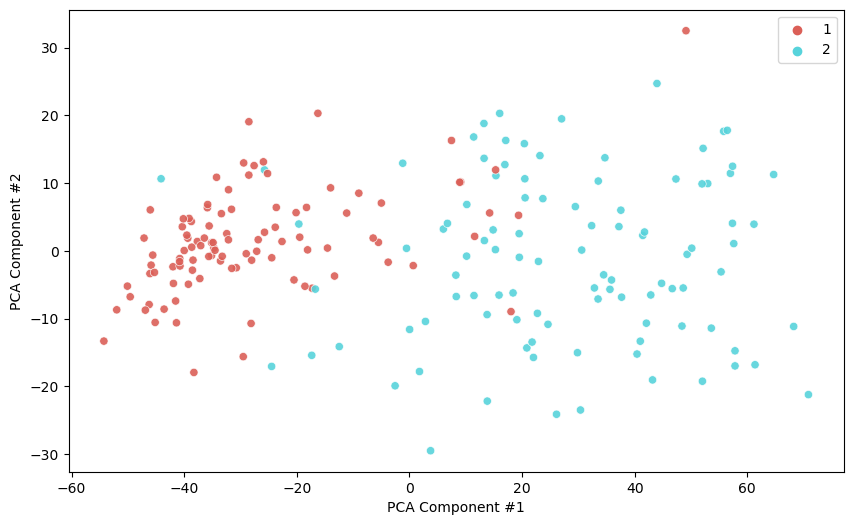

In [103]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feats)

explain = np.sum(pca.explained_variance_ratio_)
print(f"Percent of dataset explained by PCA: {explain * 100} %")

plt.figure(figsize=(10,6))

x = pca_result[:,0]
y = pca_result[:,1]

sns.scatterplot(
    x=x, y=y,
    hue=gt,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.9
)

plt.xlabel("PCA Component #1")
plt.ylabel("PCA Component #2")

## SVM on PCA features

Now, let's perform SVM on this dataset:

Accuracy: 0.91


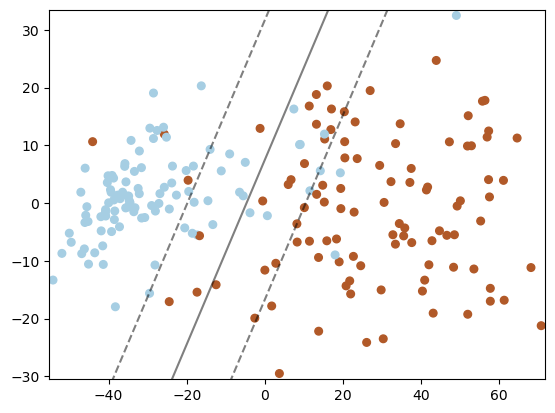

In [104]:
X = pca_result

clf = svm.SVC(kernel='linear')
clf.fit(X, gt)

plot_svm(clf, X, gt)
acc = svm_accuracy(clf, X, gt)
print(f"Accuracy: {acc}")

## Apply t-SNE

In addition to PCA, we also can use t-SNE method to reduce dimensionality of signal.
Based on observing components from t-SNE, we can visualize data and see how good they are
seperable from each other. The more two classes far from each other, the better classification
accuracy we can get.


/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_9730/2664504539.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 9.676026
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.881962
[t-SNE] KL divergence after 300 iterations: 0.150157


Text(0, 0.5, 't-SNE Component #2')

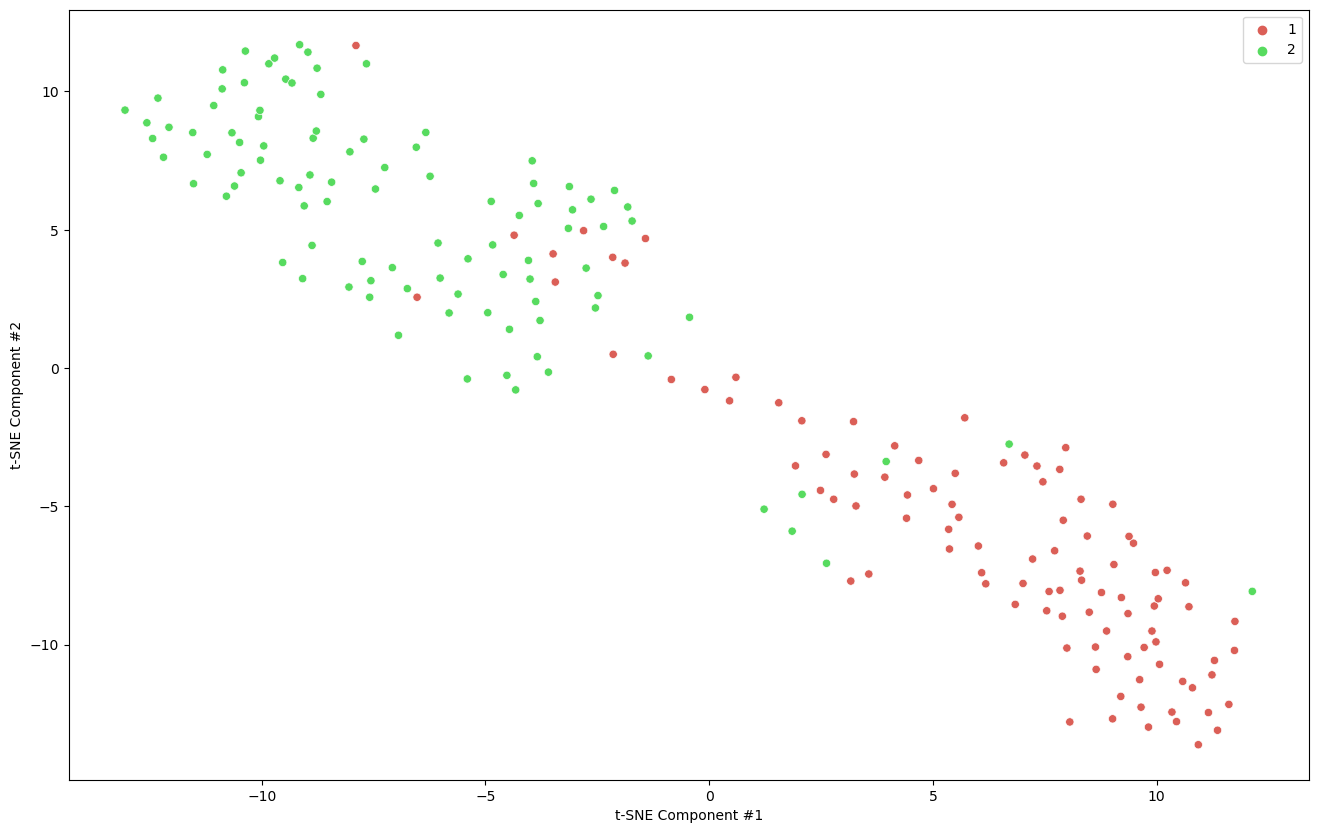

In [105]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats)


x = tsne_results[:,0]
y = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=x, y=y,
    hue=gt,
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=1
)

plt.xlabel("t-SNE Component #1")
plt.ylabel("t-SNE Component #2")

## SVM on t-SNE features

Accuracy: 0.905


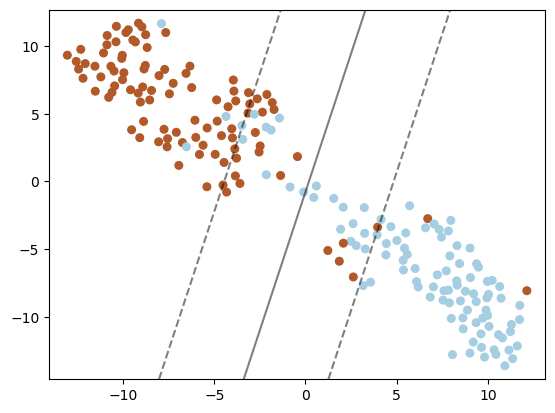

In [106]:
X = tsne_results


clf = svm.SVC(kernel='linear', C=1)
clf.fit(X, gt)

plot_svm(clf, X, gt)
acc = svm_accuracy(clf, X, gt)
print(f"Accuracy: {acc}")

# Perform STFT on vector magnitude

STFT (short-time Fourier transform) take FFT of signal over time. The result is a 2d vector of frequency and time. The procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment.

Here, by using stft function from scypi library, the stft of the vector magnitudes is computed and stored in an array.

In the figure below, you can compare STFT of two different activities. The vertical axis is frequency and horizontal axis is time. As you can see, FFT of the signal is changing over time, thus we have a localized FFT of signal which gives us an overview of what frequencies is present in each time segment.

Features shape: (200, 11, 51)


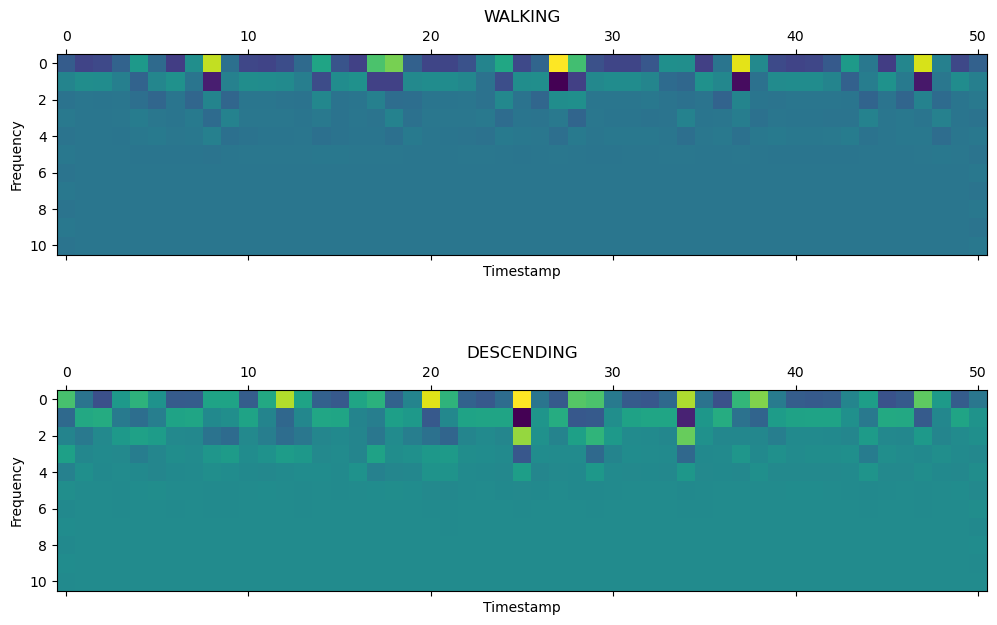

In [107]:
# To store stft of signals
stft_feats = []

# To store ground truths
gt = []


for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 20)
    _, _, z = stft(x, 1/SAMPLE_RATE, nperseg=20)
    # Normalize
    z = np.real(z)
    z = (z - z.mean()) / z.std()
    stft_feats.append(z)
    gt.append(ActivityType.WALKING.value)
    
    x = dset.get(ActivityType.DESCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 20)
    _, _, z = stft(x, 1/SAMPLE_RATE, nperseg=20)
    # Normalize
    z = np.real(z)
    z = (z - z.mean()) / z.std()
    stft_feats.append(z)
    gt.append(ActivityType.DESCENDING.value)

stft_feats = np.array(stft_feats)
print(f"Features shape: {stft_feats.shape}")

# Visualize the first two specimens
plt.figure(figsize=(12, 8))
plt.tight_layout()

for i in range(2):
    ax = plt.subplot(211 + i)
    ax.matshow(stft_feats[i])
    ax.set_title(ActivityType(gt[i]).name)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Frequency")


## Apply PCA

Percent of dataset explained by PCA: 22.9938597806721 %


Text(0.5, 0, 'PCA Component #2')

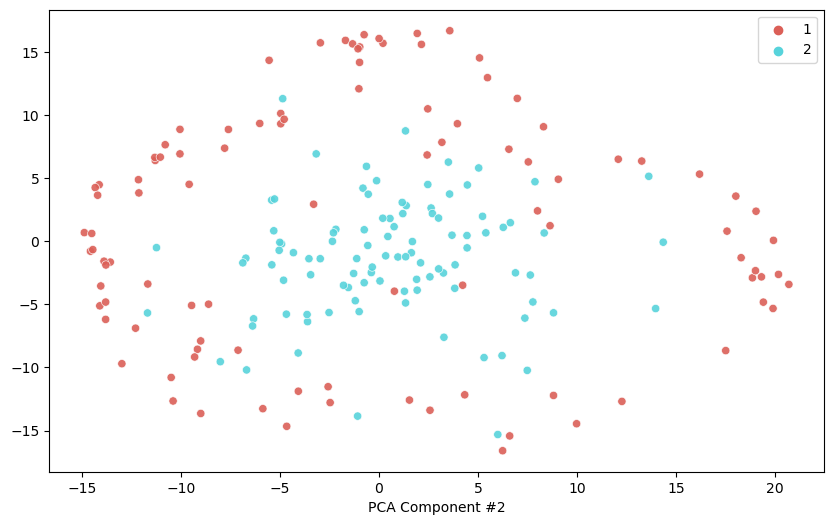

In [108]:
# Make it flat, but preserve the first dimension which is number of samples
stft_feats = stft_feats.reshape(stft_feats.shape[0], -1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(stft_feats)

explain = np.sum(pca.explained_variance_ratio_)
print(f"Percent of dataset explained by PCA: {explain * 100} %")

plt.figure(figsize=(10,6))

x = pca_result[:,0]
y = pca_result[:,1]

sns.scatterplot(
    x=x, y=y,
    hue=gt,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.9,
)

plt.xlabel("PCA Component #1")
plt.xlabel("PCA Component #2")

## SVM on PCA features

Accuracy: 0.915


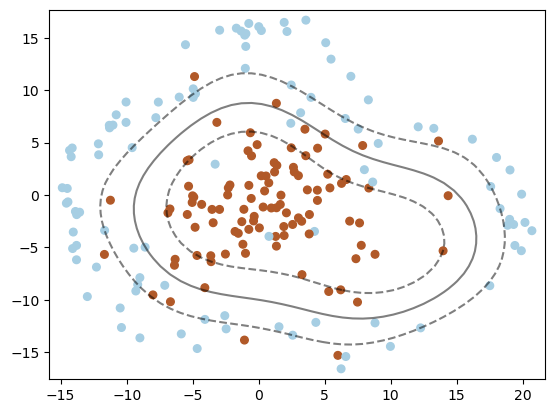

In [109]:
X = pca_result

clf = svm.SVC(kernel='rbf', C=10)
clf.fit(X, gt)

plot_svm(clf, X, gt)
acc = svm_accuracy(clf, X, gt)
print(f"Accuracy: {acc}")

# What about three activities?

## Construct features

In [111]:
raw_feats = []
gt = []

for t in np.arange(0, 100*5, 5):
    x = dset.get(ActivityType.WALKING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    raw_feats.append(x)
    gt.append(ActivityType.WALKING.value)
    
    x = dset.get(ActivityType.DESCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    raw_feats.append(x)
    gt.append(ActivityType.DESCENDING.value)
    
    x = dset.get(ActivityType.ASCENDING, Sensor.LEFT_ANKLE, start=t, duration=5)
    x = low_pass(get_magnitude(x), 12)
    raw_feats.append(x)
    gt.append(ActivityType.ASCENDING.value)

raw_feats = np.array(raw_feats)
gt = np.array(gt)
print(f"Features shape: {raw_feats.shape}")
print(f"Ground truth shape: {gt.shape}")

Features shape: (300, 500)
Ground truth shape: (300,)


## Apply PCA

Percent of dataset explained by PCA: 16.30724661228065 %


Text(0, 0.5, 'PCA Component #2')

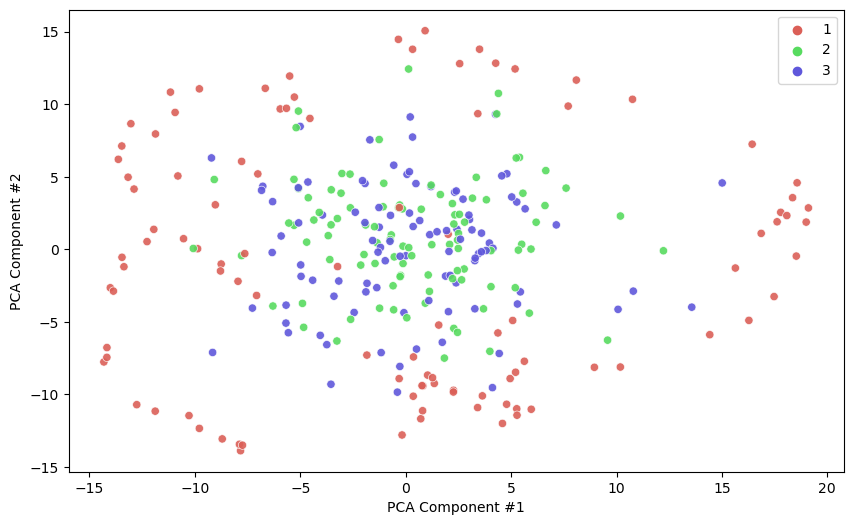

In [113]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(raw_feats)

explain = np.sum(pca.explained_variance_ratio_)
print(f"Percent of dataset explained by PCA: {explain * 100} %")

plt.figure(figsize=(10,6))

x = pca_result[:,0]
y = pca_result[:,1]

sns.scatterplot(
    x=x, y=y,
    hue=gt,
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=0.9,
)
plt.xlabel("PCA Component #1")
plt.ylabel("PCA Component #2")

## SVM on PCA components

Here you can see that SVM can't distinguish between desending and ascending activities

Accuracy: 0.65


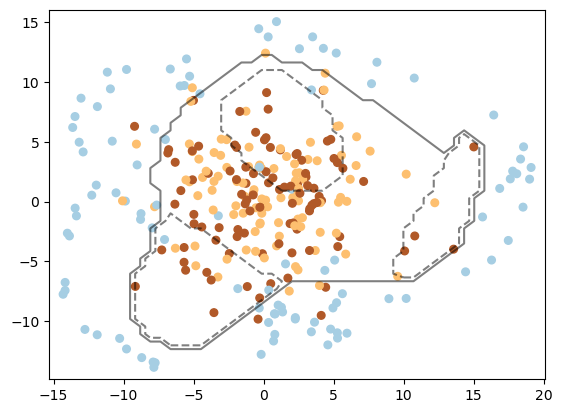

In [114]:
X = pca_result

clf = svm.SVC(kernel='rbf', C=10)
clf.fit(X, gt)

plot_svm(clf, X, gt)

acc = svm_accuracy(clf, X, gt)
print(f"Accuracy: {acc}")

## Good result with neural network

However, we achieved very good accuracy with neural network. The code is not included here, but there is resu

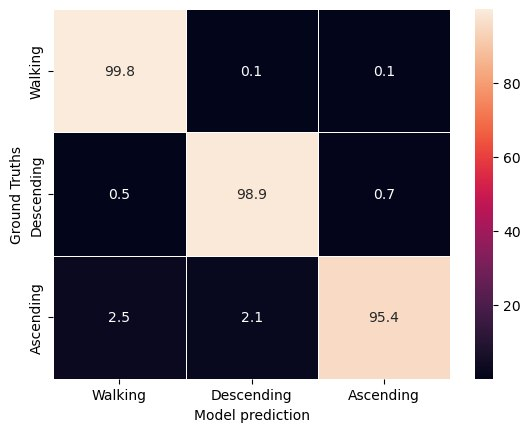

In [117]:
from IPython.display import display, Image
display(Image(filename='confusion-matrix.jpg'))